# Double Descent 
This notebook aims to help gain a better understanding of double descent by defining a neural network model and training the neural network model over increasing model capacity (# of hidden units) to see how the error of the neural network model changes over model capacity

### Imports 
Import the libraries needed to define a neural network model, train a neural network model, and measure its error and loss

In [1]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random
random.seed(0)

### Define Processor Usage 
Check which processor (CPU or GPU) can be used to run this code

In [2]:
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


### Define Data 
Download and store the MNIST-1D dataset in its respective variables

In [3]:
args = mnist1d.data.get_dataset_args()
args.num_samples = 8000
args.train_split = 0.5
args.corr_noise_scale = 0.25
args.iid_noise_scale=2e-2
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=True)

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


### Add Variance to Data 
Add a 15% noise to the output of the training data to account for variance in data output

In [4]:
for c_y in range(len(data['y'])):
    random_number = random.random()
    if random_number < 0.15 :
        random_int = int(random.random() * 10)
        data['y'][c_y] = random_int

### Define Parameter 
Define a function that initializes the parameters using He initialization to avoid the shrinking or exploding gradient problem

In [5]:
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

### Define Model
Define a neural network model with two hidden layers, each with a n_hidden amount of hidden units

In [6]:
def get_model(n_hidden):

  D_i = 40    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = 10    # Output dimensions

  # Define a model with two hidden layers, each undergoing ReLU functions
  model = nn.Sequential(
  nn.Linear(D_i, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_o))

  # Initalize parameters
  model.apply(weights_init)

  # Return the model
  return model

### Define Training Function
Define a function that fits the neural network model to the true function through stochastic gradient descent. For each 100 epoch (loop through the entire dataset), print out the neural network model's loss and error

In [7]:
def fit_model(model, data, n_epoch):
  # Define the loss function as the cross entropy loss function 
  loss_function = torch.nn.CrossEntropyLoss()
  # Define a SGD optimizer and initialize learning rate and momentum
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
  
  x_train = torch.tensor(data['x'].astype('float32'))
  y_train = torch.tensor(data['y'].transpose().astype('long'))
  x_test= torch.tensor(data['x_test'].astype('float32'))
  y_test = torch.tensor(data['y_test'].astype('long'))

  # Separate data into batches for SGD optimizer
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  # Train over multiple cycles of the entire dataset (epoch)
  for epoch in range(n_epoch):
    # Look over batches
    for i, batch in enumerate(data_loader):
      # Retrieve inputs and labels for this batch
      x_batch, y_batch = batch
      # Reset the parameter gradients
      optimizer.zero_grad()
      # Compute the forward pass to calculate model output
      pred = model(x_batch)
      # Compute the loss
      loss = loss_function(pred, y_batch)
      # Compute the backward pass to calculate the gradients for SGD update
      loss.backward()
      # SGD update
      optimizer.step()

    # Compute statistics by running the enitre dataset
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train = loss_function(pred_train, y_train).item()
    losses_test= loss_function(pred_test, y_test).item()
    if epoch%100 ==0 :
      print(f'Epoch {epoch:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f},  test loss {losses_test:.6f}, test error {errors_test:3.2f}')

  return errors_train, errors_test

### Define Capacity Function
Define a function to measure a neural network model's capacity (# of parameters)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define Hidden Units 
Define a number of different hidden units in order to determine how model behavior changes with an increasing amount of hidden units

In [9]:
hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400]) 

### Define Parameter Array Structure
Define array structures to store the error from the training set, error from the test set, and the total number of weights

In [10]:
errors_train_all = np.zeros_like(hidden_variables)
errors_test_all = np.zeros_like(hidden_variables)
total_weights_all = np.zeros_like(hidden_variables)

### Define Epoch 
Define the number of times to loop over the dataset for training

In [11]:
n_epoch = 1000

### Train Neural Network Model
Train the neural network model n_epoch times over each number of hidden units

In [12]:
for c_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[c_hidden]:3d} hidden variables')
    # Define a model
    model = get_model(hidden_variables[c_hidden]) 
    # Count and store the number of weights
    total_weights_all[c_hidden] = count_parameters(model)
    # Train the model
    errors_train, errors_test = fit_model(model, data, n_epoch)
    # Store the results (errors on train and test set)
    errors_train_all[c_hidden] = errors_train
    errors_test_all[c_hidden]= errors_test

Training model with   2 hidden variables
Epoch     0, train loss 2.302655, train error 89.90,  test loss 2.304593, test error 90.07
Epoch   100, train loss 1.884592, train error 69.95,  test loss 1.732363, test error 68.82
Epoch   200, train loss 1.872290, train error 70.80,  test loss 1.701079, test error 68.00
Epoch   300, train loss 1.865688, train error 71.30,  test loss 1.708164, test error 68.07
Epoch   400, train loss 1.861487, train error 70.93,  test loss 1.704003, test error 68.20
Epoch   500, train loss 1.859760, train error 71.00,  test loss 1.704987, test error 68.10
Epoch   600, train loss 1.859041, train error 70.97,  test loss 1.704983, test error 68.10
Epoch   700, train loss 1.861792, train error 71.50,  test loss 1.700918, test error 68.82
Epoch   800, train loss 1.860398, train error 70.57,  test loss 1.717716, test error 67.90
Epoch   900, train loss 1.858098, train error 70.80,  test loss 1.706780, test error 68.65
Training model with   4 hidden variables
Epoch   

### Determine Line where Total Weights = Number of Training Examples
Define a vertical line at the point where the total number of weights of the neural network equals the number of training examples.

In [18]:
# Compute the number of training examples
num_training_examples = len(data['y'])

# Find the index where total_weights_all is closest to num_training_examples
closest_index = np.argmin(np.abs(np.array(total_weights_all) - num_training_examples))

# Compute the corresponding value of hidden variables
hidden_variable_at_num_training_examples = hidden_variables[closest_index]

### Plot Results
Plot the error of the test set and the training set of the neural network as a function of model capacity. In addition, add the defined vertical line

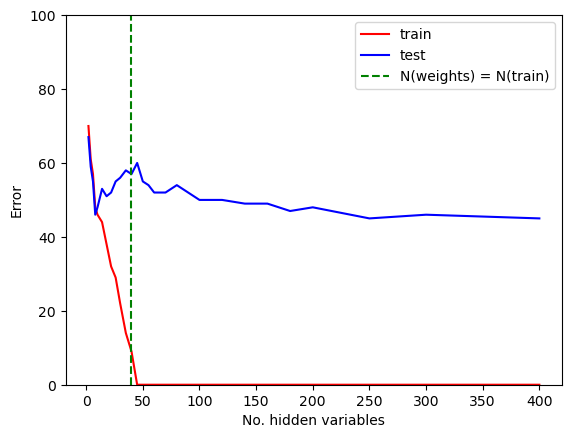

In [19]:
fig, ax = plt.subplots()
ax.plot(hidden_variables, errors_train_all, 'r-', label='train')
ax.plot(hidden_variables, errors_test_all, 'b-', label='test')

# Add a vertical line at the point where total weights equal the number of training examples
ax.axvline(x=hidden_variable_at_num_training_examples, color='g', linestyle='--', label='N(weights) = N(train)')
ax.set_ylim(0, 100)
ax.set_xlabel('No. hidden variables')
ax.set_ylabel('Error')
ax.legend()
plt.show()  